In [2]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def extract_frames(video_file, frame_nums, output_folder):
    '''
    Función para extraer frames de archivo .mp4 y guardarlos como .png
    INPUT: Video file, list with frames indexes, output folder
    OUTPUT: None
    '''
    # Abre el archivo de video
    cap = cv2.VideoCapture(video_file)

    # Verifica si el video se abrió correctamente
    if not cap.isOpened():
        print("Error al abrir el video.")
        return

    # Crea la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Itera sobre los números de frames especificados
    for frame_num in frame_nums:
        # Establece el frame en el número especificado
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        
        # Lee el frame actual
        ret, frame = cap.read()
        
        # Verifica si se leyó correctamente
        if ret:
            # Convierte el frame a escala de grises
            gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

            # Guarda el frame como imagen PNG en la carpeta de salida
            output_path = os.path.join(output_folder, f"frame_{frame_num}.png")
            cv2.imwrite(output_path, gray_frame)
            print(f"Frame {frame_num} guardado como {output_path}")
        else:
            print(f"No se pudo leer el frame {frame_num}")

    # Cierra el archivo de video
    cap.release()

    return

# Ejemplo de uso
video_file = "/Users/diegosilveracoeff/Downloads/Video_Rami.mp4"
frame_nums = [32, 33]  # Números de frames que deseas extraer
output_folder = "/Users/diegosilveracoeff/Desktop/Fing/DCM"

extract_frames(video_file, frame_nums, output_folder)


Frame 32 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png
Frame 33 guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png


In [4]:
#Armo función resta entre frames

def subtract_and_add_value(img_path1, img_path2, output_path, value=128):
    # Lee las imágenes
    img1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE).astype(np.int16)
    img2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE).astype(np.int16)

    # Verifica si las imágenes se leyeron correctamente
    if img1 is None or img2 is None:
        print("Error al leer las imágenes.")
        return

    # Realiza la resta de las imágenes
    diff_img = img1 - img2

    #Verifico el rango dinámico de la diferencia
    print('Valor mínimo de diferencia: ', np.min(diff_img))
    print('Valor máximo de diferencia: ', np.max(diff_img))
    print(np.where(diff_img == 255))
    print(diff_img[1,16])
    print(img1[1,16])
    print(img2[1,16])

    # Suma el valor especificado a cada píxel
    diff_img_adjusted = np.clip(diff_img + value, -128, 127).astype(np.uint8)

    # Guarda la imagen resultante como PNG
    cv2.imwrite(output_path, diff_img_adjusted)
    print(f"Resultado de la resta ajustado y guardado como {output_path}")

# Ejemplo de uso
img_path1 = "/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png"
img_path2 = "/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png"
output_path = "/Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames.png"

subtract_and_add_value(img_path1, img_path2, output_path)


Valor mínimo de diferencia:  -217
Valor máximo de diferencia:  221
(array([], dtype=int64), array([], dtype=int64))
-1
6
7
Resultado de la resta ajustado y guardado como /Users/diegosilveracoeff/Desktop/Fing/DCM/substract_frames.png


El rango dinámico de la resta entre los frames me puede quedar entre [-255,255], estoy tomando la decisión de diseño de sumar 128 a todos los píxeles y quedarme con valores entre [0,255]. En vez de quedar todo negro queda con grises, pero en el libro está así. Teóricamente al codificar me importa tener redundancia, sin importar el valor numérico.

Duda: Necesito que quede cerca de 0 o solo redundancia? 

(864, 480, 2)


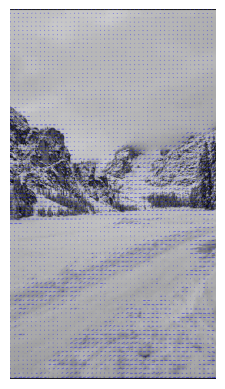

In [5]:
# Pruebo lo de los optical flows

import cv2

# Cargar las dos imágenes de entrada
prev_frame = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_32.png')
curr_frame = cv2.imread('/Users/diegosilveracoeff/Desktop/Fing/DCM/frame_33.png')

# Convertir las imágenes a escala de grises
prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
curr_gray = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2GRAY)

# Configurar parámetros para el cálculo del flujo óptico
flow_parameters = dict(
    pyr_scale=0.5,
    levels=3,
    winsize=15,
    iterations=3,
    poly_n=5,
    poly_sigma=1.2,
    flags=0
)

# Calcular el flujo óptico usando el método de Lucas-Kanade
flow = cv2.calcOpticalFlowFarneback(prev_gray, curr_gray, None, **flow_parameters)

# Visualizar el flujo óptico sobre la imagen actual
flow_visualization = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)
step = 10  # Espaciado para mostrar los vectores de flujo
for y in range(0, flow_visualization.shape[0], step):
    for x in range(0, flow_visualization.shape[1], step):
        dx, dy = flow[y, x]
        cv2.arrowedLine(flow_visualization, (x, y), (int(x + dx), int(y + dy)), (255, 0, 0), 1)

# Guardar el flujo óptico como una imagen
print(flow.shape)
#flow_image = cv2.normalize(flow, None, 0, 255, cv2.NORM_MINMAX)
np.save('/Users/diegosilveracoeff/Desktop/Fing/DCM/flow_x.npy', flow[..., 0])
np.save('/Users/diegosilveracoeff/Desktop/Fing/DCM/flow_y.npy', flow[..., 1])
cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/optical_flow_visualization.png', flow_visualization)

#TODO: Estudiar cuál es el problema de esta visualización
# Mostrar la imagen con el flujo óptico
plt.imshow(cv2.cvtColor(flow_visualization, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Ocultar ejes
plt.show()
# cv2.waitKey(0)
# cv2.destroyAllWindows()


In [17]:
# Pruebo la motion_correction
# Aplicar el flujo óptico al segundo frame
corrected_frame = np.zeros_like(curr_gray)
# corrected_frame = curr_gray
for y in range(flow.shape[0]):
    for x in range(flow.shape[1]):
        dx, dy = flow[y, x]
        x2 = min(max(x + dx, 0), flow.shape[1] - 1)
        y2 = min(max(y + dy, 0), flow.shape[0] - 1)
        corrected_frame[int(y2), int(x2)] = curr_gray[y, x]

corrected_frame_npwhere_reference_based = corrected_frame.copy()
# corrected_frame_npwhere_frame_based = corrected_frame.copy()

print(corrected_frame.shape)

for i in range(corrected_frame.shape[0]):
    for j in range(corrected_frame.shape[1]):
       corrected_frame_npwhere_reference_based[i][j] = np.where(corrected_frame_npwhere_reference_based[i][j] == 0, prev_gray[i][j], corrected_frame_npwhere_reference_based[i][j])
       # corrected_frame_npwhere_frame_based[i][j] = np.where(corrected_frame_npwhere_frame_based[i][j] == 0, curr_gray[i][j], corrected_frame_npwhere_frame_based[i][j])

# print(np.min(corrected_frame_npwhere_frame_based))
cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/motion_corrected_frame_npwhere_reference_based.png', corrected_frame_npwhere_reference_based)
# cv2.imwrite('/Users/diegosilveracoeff/Desktop/Fing/DCM/motion_corrected_frame_npwhere_frame_based.png', corrected_frame_npwhere_frame_based)

(864, 480)
0


True

Acá estaba trabajando con dos opciones para sustituir los valores negros, siendo uno tomar los valores originales del frame de referencia, y otro tomando los valores originales del frame actual. Este último no tiene sentido, dado que el decodificador no va a contar con el frame actual, por lo que queda descartado.